In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
from sklearn.utils import shuffle

In [6]:
#utworze teraz dane jakies
def kolko_w_kolku(sig1=0.4,sig2=0.6,R2=1.,N=1000):
    """to ma utworzyc dane ktore posluza mi do sprawdzenia czy i jak dziala model"""
    features=[]
    labels=[]
    for i in range(N):
        x=np.random.normal(0,sig1)
        y=np.random.normal(0,sig1)
        features.append([x,y])
        labels.append(0)
    for i in range(N):
        alpha=np.random.uniform()*2*np.pi
        delr=np.random.normal(0,sig2)
        r=R2+delr
        x=np.cos(alpha)*r
        y=np.sin(alpha)*r
        features.append([x,y])
        labels.append(1)
    features=np.array(features)
    labels=np.array(labels)
    features,labels=shuffle(features,labels)
    return features,labels

In [7]:
def rysoj_dane(f,l):
    plt.clf()
    plt.scatter(f[:,0],f[:,1],c=l,s=5)

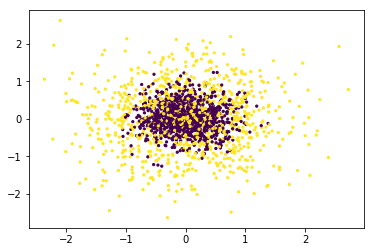

In [8]:
f,l=kolko_w_kolku()
rysoj_dane(f,l)

In [9]:
#teraz sproboje z tego zrobic jakis dataset

In [10]:
#f,l=kolko_w_kolku()

In [11]:
#dataset = tf.data.Dataset.from_tensor_slices((f,l))

In [12]:
#BATCH_SIZE=100
#zbachowany=dataset.shuffle(1000).repeat().batch(BATCH_SIZE)

In [13]:
#to jest dataset zaraz zastanowie sie jak go zapisac do pliku i z tego pliku odczytac a teraz jak go czytac?

In [14]:
#iterator = zbachowany.make_one_shot_iterator()

In [15]:
#f,l=iterator.get_next()

In [16]:
#with tf.Session() as sess:
#    for i in range(100):
#        sess.run(l)
    

In [17]:
#wrap_float64([5.55,6.85]) #swietnie

In [27]:
def wrap_int64(value):
    """lista intow musi wlesc"""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
def wrap_float64(value):
    """lista floatow musi wlesc"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

"""
Teraz ta funkcja wpisz jest ważna. ona bierze po jednym przypadku testowym, 
( to jest ta petla for i in range()) i go zapisuje. trzeba zwracac 
uwage na to jakiego typu sa zapisywane rzeczy. mozna oczywiscie zrobic slownik
data dluzszym, jesli to w jakis sposob ulatwi nam myslenie o naszych danych. 
Bo te nasze dane to bedzie slownik list, w ktorych to listach rzeczy maja 
juz taki sam typ, a klucze to beda jakies opisowe nazwy.
np 

data={
'czteroped_lewej_nogi_czy_cos': wrap_float64(cztero), # gdzie cztero to jest tensor floatow o shape (4,)
# reszta rzeczy

}

Jak byscie chcieli jako wartosci miec stringi to musicie pomyslec jak zrobic wrapy dla stringow. oczywiscie
nie znajdziecie zadnej dokumentacji. 





"""


def wpisz(out_path):
    """tworzy ten nasz dataset w pliku out_path """
    f,l=kolko_w_kolku() #mozna zmienic jak sie podoba
    with tf.python_io.TFRecordWriter(out_path) as writer:
        for i in range(len(f)):
            feature=f[i]
            label=l[i]
            data = {
                 'feature': wrap_float64(feature),
                'label': wrap_int64([label])
                    }
            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)

            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)

            # Serialize the data.
            serialized = example.SerializeToString()

            # Write the serialized data to the TFRecords file.
            writer.write(serialized)
    
        
    

In [28]:
wpisz("dane_treningowe")

In [29]:
"""
Teraz funkcja wczytujaca ten nasz dataset. 
Z ciekawych rzeczy to zwroccie uwage, ze jak wczytamy do binarnych nasz dataset to 
tracimy informacje o tym jakiego typu sa dane. Z tego powodu trzeba to ponownie dookreslac
co jest strasznie glupie. 

czyli to jest ten slownik features w ponizszej funkcji  ktory musi byc zgodny z slownikiem data z funkcji wpisz

"""



def wczytaj_dataset(file_path):
    """Wczytuje dataset po prostu jeszcze nie robi z nim nic szczegolnego"""
    def parse(serialized):
        """ta funkcja pomocnicza dla jednego przypadku ktory nie pamieta jakiego jest typu mu przypomina
        smutne ze trzeba takie rzeczy pisac"""
        # Define a dict with the data-names and types we expect to
        # find in the TFRecords file.
        # It is a bit awkward that this needs to be specified again,
        # because it could have been written in the header of the
        # TFRecords file instead.
        features = \
            {
                'feature': tf.FixedLenFeature([2], tf.float32),#z jakiegos powodu to jest float32, nie wiem czemu
                'label': tf.FixedLenFeature([], tf.int64)
            }

        # Parse the serialized data so we get a dict with our data.
        parsed_example = tf.parse_single_example(serialized=serialized,
                                                 features=features)
        return parsed_example['feature'], parsed_example['label']
    
    dataset = tf.data.TFRecordDataset(file_path)
    dataset = dataset.map(parse)
    return dataset

In [39]:
dataset=wczytaj_dataset("dane_treningowe")

In [40]:
def zrob_slownik(dataset):
    """ chodzi o to, zeby bylo { features}, labels tak jak lubi estymator"""
    def f(*x):
        f1=x[0]
        l=x[1]
        return {"pierwszy_feature":f1},l
    dataset=dataset.map(f)
    return dataset

In [41]:
dataset=zrob_slownik(dataset)

In [42]:
BATCH_SIZE=3
zbachowany=dataset.shuffle(1000).repeat().batch(BATCH_SIZE)
iterator = zbachowany.make_one_shot_iterator()
f,l=iterator.get_next()
with tf.Session() as sess:
    for i in range(10):
        print(sess.run(f["pierwszy_feature"]))
    

[[-0.35050318  0.31055012]
 [ 0.19902241  0.35131431]
 [-0.47109327  0.47194394]]
[[-0.67984456 -0.41269502]
 [-0.5371834   0.61032361]
 [-0.66193551 -0.12152335]]
[[ 0.9949711  -0.45094842]
 [ 0.1176976  -0.26324096]
 [ 0.96977246 -0.52668273]]
[[-1.12244463  0.83105016]
 [ 0.17174587  0.2966167 ]
 [ 0.22127967 -1.61718798]]
[[-1.4635222  -0.26938716]
 [ 0.46605188 -0.94659984]
 [ 0.2435403   0.04423222]]
[[ 0.44245589 -0.11612175]
 [-1.56782651 -0.04932832]
 [-0.12016894 -0.3218351 ]]
[[ 0.40241984 -0.25238931]
 [ 0.23628469 -0.29954329]
 [ 0.09980488  0.15886262]]
[[ 0.01548058  0.68580294]
 [ 0.14129803  1.22756994]
 [ 0.32337925  0.73691279]]
[[ 1.32239389  0.90172273]
 [ 0.1981761  -0.33294073]
 [ 0.77693141  0.35733402]]
[[-0.65555102  0.57061583]
 [ 0.12989967  0.11412634]
 [-0.19438824  1.29611766]]
